In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
import scipy.special as special
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
from tqdm import tqdm

#you need ffmpeg package installed

plt.rcParams['animation.embed_limit'] = 2**128

In [52]:
TrueG = (6.67430 * (10**(-11)) * u.m**3 / (u.kg * u.second**2)) 
SolG = TrueG.to(u.AU**3/(u.solMass * u.year**2))
milkmass = u.def_unit('milkmass', 1.15*(10**12) * u.solMass)
milkrad =  u.def_unit('milkrad', 30 * u.kiloparsec)
MilkG = TrueG.to(milkrad**3/(milkmass * u.megayear**2))


def generate_3d_exponential_cylindrical(n, radius, height):
    """
    Generate 3D coordinates in cylindrical space where the radial distance follows
    a radial exponential distribution and z-coordinates are uniformly distributed.

    Parameters:
    - n: Number of points to generate.
    - lambda_r: Rate parameter (λ) for the radial distance's exponential distribution.
    - z_min: Minimum z-coordinate.
    - z_max: Maximum z-coordinate.

    Returns:
    - A numpy array of shape (n, 3) containing the 3D coordinates.
    """
    # Radial distances
    r = np.random.exponential(radius, n)
    
    # Azimuthal angle, theta, uniformly distributed between 0 and 2pi
    theta = np.random.uniform(0, 2 * np.pi, n)
    
    # z-coordinates uniformly distributed
    z = np.random.uniform(-height/2, height/2, n)
    
    # Convert cylindrical coordinates to Cartesian coordinates
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    return np.vstack((x, y, z)).T



def exponentialdiskvelocity(G, M, Rdisk, R):
    '''
    Calculates the angular velocity of an object at a certain radial distance 
    within an exponential disk galaxy using a simplified model. This function 
    assumes an exponential disk mass distribution and utilizes specific Bessel 
    functions to estimate the velocity.

    Parameters:
    - G (float): Gravitational constant. Ensure consistent units are used
                 throughout all parameters.
    - M (float): Total mass of the galaxy or the mass enclosed within a certain
                 radius. Again, consistent units with G are essential.
    - Rdisk (float): Scale length of the galaxy's exponential disk. This parameter
                     defines how rapidly the disk's density decreases with radius
                     from the center of the galaxy.
    - R (float or array_like): Radial distance(s) from the center of the galaxy 
                               at which to calculate the angular velocity. Can be
                               a single value or an array of values for calculating
                               velocities at multiple radii simultaneously.

    Returns:
    - vels (float or ndarray): The angular velocity (or velocities if R is an array) 
                               at the specified radial distance(s) from the galaxy's 
                               center. The return type matches the input type of R.

    Notes:
    - This function uses the special.iv (modified Bessel function of the first kind)
      and special.kv (modified Bessel function of the second kind) from the SciPy
      library to compute the velocities. Ensure SciPy is installed and imported
      correctly in your environment.

    Example:
    ```python
    import numpy as np
    from scipy import special
    G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
    M = 1e11  # Mass of the galaxy in kg
    Rdisk = 3.5e3  # Scale length of the galaxy's disk in light-years
    R = np.array([8000, 15000])  # Radial distances in light-years
    velocities = exponentialdiskvelocity(G, M, Rdisk, R)
    print(velocities)
    ```

    The output will be the angular velocities at the specified radial distances.
    '''
    yvals = R/(2*Rdisk)
    frontvalus = ((2*G*M)/Rdisk) * yvals**2
    bessels = (special.iv(0,yvals) * special.kv(0,yvals)) - (special.iv(1,yvals) * special.kv(1,yvals))
    vels = np.sqrt(frontvalus*bessels)
    return vels

def normalize_vectors(vectors):
    """
    Normalize a list or array of 3D vectors to their unit vectors.
    
    Parameters:
    - vectors: A list or a numpy array of shape (n, 3) where n is the number of vectors
    
    Returns:
    - A numpy array of shape (n, 3) containing the unit vectors.
    """
    vectors = np.array(vectors)  # Ensure input is converted to a numpy array
    magnitudes = np.linalg.norm(vectors, axis=1)[:, np.newaxis]  # Calculate magnitudes and reshape for broadcasting
    unit_vectors = vectors / magnitudes  # Normalize
    
    return unit_vectors

def radiuscalc2Dcylinder(vectors):
    ''' 
    takes array of 3D vectors and calculates their radial position 
    '''
    radvectors = np.sqrt( (vectors[:,0])**2 + (vectors[:,1])**2)
    return radvectors 


class Galaxy():
    '''
    N = number of particles in galaxy 
    mass = mass of galaxy 
    k = equation of state constant
	n = polytropic index
    pressure when simulating follows 
    '''
    def __init__(self, N, mass, radius, scaleheight, randvel,G =0.00019160287,  k = 0.4246 , n = 4/3, nu = 0.1):
        #stored constants 
        self.particles = N
        self.mass = mass    
        self.radius = radius
        self.scaleheight = scaleheight
        self.randomvel = randvel
        self.Grav = G
        self.konstant = k
        self.pindex = n
        self.viscosity = nu
        self.simulation = None 
        #generate the galaxy 
        print('...generating galaxy')
        self.particlemass = self.mass/self.particles * np.ones(self.particles)
        self.positions = generate_3d_exponential_cylindrical(self.particles, self.radius, self.scaleheight)  
        self.radialvelocities =  exponentialdiskvelocity( self.Grav,self.mass,self.radius, radiuscalc2Dcylinder(self.positions) )
        self.randomvelocities = self.randomvel * np.random.randn(self.particles, 3)
        self.velocities = (normalize_vectors(np.cross(self.positions, [0,0,1])) * (self.radialvelocities)[:, np.newaxis]) + self.randomvelocities
        print('...galaxy generated')
        
    def regenerate(self):
        #generate the galaxy 
        print('...generating galaxy')
        self.particlemass = self.mass/self.particles * np.ones(self.particles)
        self.positions = generate_3d_exponential_cylindrical(self.particles, self.radius, self.scaleheight)   
        self.radialvelocities =  exponentialdiskvelocity( self.Grav,self.mass,self.radius, radiuscalc2Dcylinder(self.positions) )
        self.randomvelocities = self.randomvel * np.random.randn(self.particles, 3)
        self.velocities = (normalize_vectors(np.cross(self.positions, [0,0,1])) * (self.radialvelocities)[:, np.newaxis]) + self.randomvelocities
        print('...galaxy generated')

    def simulate(self, smoothinglength, tstep, tEnd, tStart = 0):
        self.simulation = simulate( N = self.particles, tStart = tStart, tstep = tstep, tEnd = tEnd, pos = self.positions, vel = self.velocities, masses = self.particlemass, 
                                    h = smoothinglength, k =  self.konstant, n = self.pindex, nu = self.viscosity, G = self.Grav, simradius = self.radius, plotRealTime = True) 
        return self.simulation
    def plot(self, time, orientation = 'top', xlim = None, ylim =None, cmap = plt.cm.autumn, alpha=0.25,  s=10, **kwargs):

        if self.simulation is None:
            print('NO SIMULATION HAS BEEN RUN YET')
            return

        if xlim is None:
            xlim = (-4.5*self.radius, 4.5*self.radius)
        if ylim is None:
            ylim = (-4.5*self.radius, 4.5*self.radius)
            
        posarr = self.simulation[0]
        colarr = self.simulation[1]
        t = timepull(self.simulation, time)
        print(f'Graphed at time {self.simulation[2][t]}')

        fig, ax = plt.subplots()
        ax.set_facecolor('black')
        ax.set_facecolor((.1,.1,.1))
        if orientation == 'top':
            plt.scatter(posarr[t][:,0], posarr[t][:,1], c=(colarr[t]), cmap=cmap, alpha = alpha , s = s, **kwargs )
        elif orientation == 'side':
            plt.scatter(posarr[t][:,0], posarr[t][:,2], c=(colarr[t]), cmap=cmap, alpha = alpha , s = s, **kwargs )
        else:
            print('NOT A VALID VIEWING DIRECTION')
        plt.xlim(xlim)
        plt.ylim(ylim)
    def quadplot(self, time, xlim1 = None, ylim1 =None, xlim2 =None, ylim2 = None,  xlim3 = None, ylim3 = None, 
                  xlim4 = None, ylim4 = None, cmap = plt.cm.autumn, alpha=0.25,  s=10, **kwargs):
        if self.simulation is None:
            print('NO SIMULATION HAS BEEN RUN YET')
            return

        if xlim1 is None:
            xlim1 = (-4.5*self.radius, 4.5*self.radius)
        if ylim1 is None:
            ylim1 = (-4.5*self.radius, 4.5*self.radius)
        if xlim2 is None:
            xlim2 = (-4.5*self.radius, 4.5*self.radius)
        if ylim2 is None:
            ylim2 = (-4.5*self.radius, 4.5*self.radius)
        if xlim3 is None:
            xlim3 = (-self.radius, self.radius)
        if ylim3 is None:
            ylim3 = (-self.radius, self.radius)
        if xlim4 is None:
            xlim4 = (-10*self.radius, 10*self.radius)
        if ylim4 is None:
            ylim4 = (-10*self.radius, 10*self.radius)

        
        posarr = self.simulation[0]
        colarr = self.simulation[1]
        t = timepull(self.simulation, time)
        print(f'Graphed at time {self.simulation[2][t]}')
        fig = plt.figure(figsize=(10,12), dpi=100)
        grid = plt.GridSpec(2, 2, wspace=0.0, hspace=0.3)
        ax1 = plt.subplot(grid[0,0])
        ax2 = plt.subplot(grid[0,1])
        ax3 = plt.subplot(grid[1,0])
        ax4 = plt.subplot(grid[1,1])
        ax1.cla()
        ax2.cla()
        ax3.cla()
        ax4.cla()
    
        ax1.set(xlim=xlim1, ylim=ylim1)
        ax1.set_aspect('equal', 'box')
        ax1.set_xticks([-1,0,1])
        ax1.set_yticks([-1,0,1])
        ax1.set_facecolor('black')
        ax1.set_facecolor((.1,.1,.1))
        ax1.scatter(posarr[t][:,0], posarr[t][:,1], c=(colarr[t]), cmap=cmap, s=s, alpha=alpha, **kwargs)
    
        ax2.set(xlim=xlim2, ylim=ylim2)
        ax2.set_aspect('equal', 'box')
        ax2.set_xticks([-1,0,1])
        ax2.set_yticks([-1,0,1])
        ax2.set_facecolor('black')
        ax2.set_facecolor((.1,.1,.1)) 
        ax2.scatter(posarr[t][:,0], posarr[t][:,2], c=(colarr[t]), cmap=cmap, s=s, alpha=alpha, **kwargs)

        ax3.set(xlim=xlim3, ylim=ylim3)
        ax3.set_aspect('equal', 'box')
        ax3.set_xticks([-1,0,1])
        ax3.set_yticks([-1,0,1])
        ax3.set_facecolor('black')
        ax3.set_facecolor((.1,.1,.1))
        ax3.scatter(posarr[t][:,0], posarr[t][:,1], c=(colarr[t]), cmap=cmap, s=s, alpha=alpha, **kwargs)
    
        ax4.set(xlim=xlim4, ylim=ylim4)
        ax4.set_aspect('equal', 'box')
        ax4.set_xticks([-1,0,1])
        ax4.set_yticks([-1,0,1])
        ax4.set_facecolor('black')
        ax4.set_facecolor((.1,.1,.1))
        ax4.scatter(posarr[t][:,0], posarr[t][:,1], c=(colarr[t]), cmap=cmap, s=s, alpha=alpha, **kwargs)
    def plotvid((self, downsampling=1, orientation = 'top', xlim = None, ylim =None, cmap = plt.cm.autumn, alpha=0.25,  s=10, **kwargs):
        if self.simulation is None:
            print('NO SIMULATION HAS BEEN RUN YET')
            return
        if xlim is None:
            xlim = (-4.5*self.radius, 4.5*self.radius)
        if ylim is None:
            ylim = (-4.5*self.radius, 4.5*self.radius)
        print('unfinished')
    def quadplotvid(self, downsampling=1, xlim1 =None, ylim1 =None, xlim2 = None, ylim2 =None,  xlim3 = None, 
                    ylim3 = None, xlim4 = None, ylim4 = None, cmap = plt.cm.autumn, alpha=0.25,  s=10, **kwargs):
        if self.simulation is None:
            print('NO SIMULATION HAS BEEN RUN YET')
            return
        
        if xlim1 is None:
            xlim1 = (-4.5*self.radius, 4.5*self.radius)
        if ylim1 is None:
            ylim1 = (-4.5*self.radius, 4.5*self.radius)
        if xlim2 is None:
            xlim2 = (-4.5*self.radius, 4.5*self.radius)
        if ylim2 is None:
            ylim2 = (-4.5*self.radius, 4.5*self.radius)
        if xlim3 is None:
            xlim3 = (-self.radius, self.radius)
        if ylim3 is None:
            ylim3 = (-self.radius, self.radius)
        if xlim4 is None:
            xlim4 = (-10*self.radius, 10*self.radius)
        if ylim4 is None:
            ylim4 = (-10*self.radius, 10*self.radius)
        
        
        # Downsampling by selecting every nth point
        posarr = self.simulation[0]
        colarr = self.simulation[1]
        
        positions1 = posarr[::downsampling]
        colors1 = colarr[::downsampling] 

    
        def update_plot(i):
            ax1.cla()
            ax2.cla()
            ax3.cla()
            ax4.cla()
            
    
            ax1.set(xlim=xlim1, ylim=ylim1)
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1,0,1])
            ax1.set_yticks([-1,0,1])
            ax1.set_facecolor('black')
            ax1.set_facecolor((.1,.1,.1))
            ax1.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]),  cmap=cmap, s=s, alpha=alpha, **kwargs)
    
            ax2.set(xlim=xlim2, ylim=ylim2)
            ax2.set_aspect('equal', 'box')
            ax2.set_xticks([-1,0,1])
            ax2.set_yticks([-1,0,1])
            ax2.set_facecolor('black')
            ax2.set_facecolor((.1,.1,.1)) 
            ax2.scatter(positions1[i][:,0], positions1[i][:,2], c=(colors1[i]), cmap=cmap, s=s, alpha=alpha, **kwargs)

            ax3.set(xlim=xlim3, ylim=ylim3)
            ax3.set_aspect('equal', 'box')
            ax3.set_xticks([-1,0,1])
            ax3.set_yticks([-1,0,1])
            ax3.set_facecolor('black')
            ax3.set_facecolor((.1,.1,.1))
            ax3.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]),  cmap=cmap, s=s, alpha=alpha, **kwargs)
    
            ax4.set(xlim=xlim4, ylim=ylim4)
            ax4.set_aspect('equal', 'box')
            ax4.set_xticks([-1,0,1])
            ax4.set_yticks([-1,0,1])
            ax4.set_facecolor('black')
            ax4.set_facecolor((.1,.1,.1))
            ax4.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]),  cmap=cmap, s=s, alpha=alpha, **kwargs)

        fig = plt.figure(figsize=(10,12), dpi=100)
        grid = plt.GridSpec(2, 2, wspace=0.0, hspace=0.3)
        ax1 = plt.subplot(grid[0,0])
        ax2 = plt.subplot(grid[0,1])
        ax3 = plt.subplot(grid[1,0])
        ax4 = plt.subplot(grid[1,1])

        #positions, colors = main()
        ani = FuncAnimation(fig, update_plot, frames=len(positions1), interval=50, repeat=False)
        
        display(HTML(ani.to_jshtml()))
        
        return ani

            
            
            
        
        


SyntaxError: invalid syntax (3517976357.py, line 254)

In [48]:
"""
Create Your Own Smoothed-Particle-Hydrodynamics Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz

Simulate the structure of a star with SPH
"""

def W( x, y, z, h ):
	"""
    Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	w     is the evaluated smoothing function
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	w = (1.0 / (h*np.sqrt(np.pi)))**3 * np.exp( -r**2 / h**2)
	
	return w
	
	
def gradW( x, y, z, h ):
	"""
	Gradient of the Gausssian Smoothing kernel (3D)
	x     is a vector/matrix of x positions
	y     is a vector/matrix of y positions
	z     is a vector/matrix of z positions
	h     is the smoothing length
	wx, wy, wz     is the evaluated gradient
	"""
	
	r = np.sqrt(x**2 + y**2 + z**2)
	
	n = -2 * np.exp( -r**2 / h**2) / h**5 / (np.pi)**(3/2)
	wx = n * x
	wy = n * y
	wz = n * z
	
	return wx, wy, wz
	
	
def getPairwiseSeparations( ri, rj ):
	"""
	Get pairwise desprations between 2 sets of coordinates
	ri    is an M x 3 matrix of positions
	rj    is an N x 3 matrix of positions
	dx, dy, dz   are M x N matrices of separations
	"""
	
	M = ri.shape[0]
	N = rj.shape[0]
	
	# positions ri = (x,y,z)
	rix = ri[:,0].reshape((M,1))
	riy = ri[:,1].reshape((M,1))
	riz = ri[:,2].reshape((M,1))
	
	# other set of points positions rj = (x,y,z)
	rjx = rj[:,0].reshape((N,1))
	rjy = rj[:,1].reshape((N,1))
	rjz = rj[:,2].reshape((N,1))
	
	# matrices that store all pairwise particle separations: r_i - r_j
	dx = rix - rjx.T
	dy = riy - rjy.T
	dz = riz - rjz.T
	
	return dx, dy, dz
	

def getDensity( r, pos, m, h ):
    
    """
    Get Density at sampling loctions from SPH particle distribution
    r     is an M x 3 matrix of sampling locations
    pos   is an N x 3 matrix of SPH particle positions
    m     is the particle mass
    h     is the smoothing length
    rho   is M x 1 vector of densities
    """
    M = r.shape[0]
	
    dx, dy, dz = getPairwiseSeparations( r, pos );

    rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1)) #CHECK IF THIS MULTIPLICATION IS CORRECT

    return rho
	
	
def getPressure(rho, k, n):
	"""
	Equation of State
	rho   vector of densities
	k     equation of state constant
	n     polytropic index
	P     pressure
	"""
	
	P = k * rho**(1+1/n)
	
	return P

def arbacalc3d_vectorized(G, positions, masses):
    n_objects = len(masses)
    accels = np.zeros((n_objects, 3))
    
    # Expand dimensions to support broadcasting for pairwise subtraction
    pos_expanded = positions[:, np.newaxis, :]  # Shape: (n_objects, 1, 2)
    masses_expanded = masses[:, np.newaxis]  # Shape: (n_objects, 1)
    
    # Compute pairwise differences in positions and distances
    delta_pos = pos_expanded - positions  # Shape: (n_objects, n_objects, 2)
    distances = np.linalg.norm(delta_pos, axis=2)  # Shape: (n_objects, n_objects)
    
    # Avoid division by zero for the same object by setting distance to np.inf
    np.fill_diagonal(distances, np.inf)
    
    # Compute the acceleration due to gravity
    # Add an axis to distances to support broadcasting in division
    acc_due_to_gravity = -G * delta_pos * masses_expanded / distances[:,:,np.newaxis] ** 3  # Shape: (n_objects, n_objects, 2)
    
    # Sum the contributions from all other masses, ignoring the diagonal (self-contribution)
    accels = np.sum(acc_due_to_gravity, axis=1)
    
    return accels

def radpressure(G, positions, masses):
    n_objects = len(masses)
    accels = np.zeros((n_objects, 3))
    
    # Expand dimensions to support broadcasting for pairwise subtraction
    pos_expanded = positions[:, np.newaxis, :]  # Shape: (n_objects, 1, 2)
    masses_expanded = masses[:, np.newaxis]  # Shape: (n_objects, 1)
    
    # Compute pairwise differences in positions and distances
    delta_pos = pos_expanded - positions  # Shape: (n_objects, n_objects, 2)
    distances = np.linalg.norm(delta_pos, axis=2)  # Shape: (n_objects, n_objects)
    
    # Avoid division by zero for the same object by setting distance to np.inf
    np.fill_diagonal(distances, np.inf)
    
    # Compute the acceleration due to gravity
    # Add an axis to distances to support broadcasting in division
    acc_due_to_gravity = -G * delta_pos * masses_expanded / distances[:,:,np.newaxis] ** 3  # Shape: (n_objects, n_objects, 2)
    
    # Sum the contributions from all other masses, ignoring the diagonal (self-contribution)
    accels = np.sum(acc_due_to_gravity, axis=1)
    
    return accels



def getAcc( pos, vel, m, h, k, n, nu, G ):
    
    """
    Calculate the acceleration on each SPH particle
    pos   is an N x 3 matrix of positions
    vel   is an N x 3 matrix of velocities
    m     is the particle mass
    h     is the smoothing length
    k     equation of state constant
    n     polytropic index
    nu    viscosity
    a     is N x 3 matrix of accelerations
    """
    N = pos.shape[0]
	
	# Calculate densities at the position of the particles
    rho = getDensity( pos, pos, m, h )
	
	# Get the pressures
    P = getPressure(rho, k, n)

	# Get pairwise distances and gradients
    dx, dy, dz = getPairwiseSeparations( pos, pos )
    dWx, dWy, dWz = gradW( dx, dy, dz, h )
	
	# Add Pressure contribution to accelerations
    ax = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWx, 1).reshape((N,1))
    ay = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWy, 1).reshape((N,1))
    az = - np.sum( m * ( P/rho**2 + P.T/rho.T**2  ) * dWz, 1).reshape((N,1))
	
	# pack together the acceleration components
    a = np.hstack((ax,ay,az))
	
	# Add external potential force
    a += arbacalc3d_vectorized(G, pos, m*(np.ones(len(pos))))
	
	# Add viscosity
    a -= nu * vel
    return a

In [49]:
 # Simulation parameters
N         = 5000    # Number of particles
t         = 0      # current time of the simulation
tEnd      = 15     # time at which simulation ends
dt        = 1   # timestep
M         = 1      # star mass
R         = 1   # star radius
#h         = 0.02    # smoothing length
h         = 0.04    # smoothing length
k         = 0.00001    # equation of state constant
#k        = 0.000002    # equation of state constant
n         = 4/3      # polytropic index
nu        = 0.000003     # damping
G         = 0.00019160287    #gravitational acceleration 
plotRealTime = True # switch on for plotting as the simulation goes along

def simulate(N, tstep, tEnd, pos, vel, masses, h, k, nu, G, plotRealTime = True, tStart = 0,  n = 4/3, simradius = 1):
    
    t = tStart
    
    # calculate initial gravitational accelerations
    acc = getAcc( pos, vel, masses, h, k, n, nu, G )
	
    # number of timesteps
    Nt = int(np.ceil(tEnd/tstep))

    positions = np.zeros(shape = (Nt, N, 3))
    colors = np.zeros(shape = (Nt, N))
    times = np.zeros(shape = Nt)
    notstars = np.full(N, True) 

    # prep figure
    fig = plt.figure(figsize=(10,12), dpi=100)
    grid = plt.GridSpec(3, 3, wspace=0.0, hspace=0.3)
    ax1 = plt.subplot(grid[0:1,0:1])
    ax2 = plt.subplot(grid[1:2,0:1])
    ax3 = plt.subplot(grid[0:1,1:2])
    ax4 = plt.subplot(grid[1:2,1:2])
	
    # Simulation Main Loop
    for i in tqdm(range(Nt)):
		# (1/2) kick
        vel += acc * dt/2
		
		# drift
        pos += vel * dt
		
		# update accelerations
        acc = getAcc( pos, vel, masses, h, k, n, nu, G )
		
		# (1/2) kick
        vel += acc * dt/2
		
		# update time
        t += dt
		
		# get density for plotting
        rho = getDensity( pos, pos, masses, h )

        #figure out if gas has become star forming matter (False if matter is star forming) 
        newstar = (rho < 10) ################################ USING A TEST VALUE change 10 t0 an actual variable #######################################################
        notstars = notstars * newstar.T
        
        #colors for density plotting 
        cval = np.minimum((rho-3)/3,1).flatten()
		
		# plot in real time
        if plotRealTime or (i == Nt-1):

            clear_output(wait=True)
            plt.sca(ax1)
            plt.cla()
            plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.25)
            ax1.set(xlim=(-4.5 * simradius, 4.5* simradius), ylim=(-4.5*simradius, 4.5*simradius))
            ax1.set_aspect('equal', 'box')
            ax1.set_xticks([-1,0,1])
            ax1.set_yticks([-1,0,1])
            ax1.set_facecolor('black')
            ax1.set_facecolor((.1,.1,.1))

            plt.sca(ax2)
            plt.cla()
            plt.scatter(pos[:,0],pos[:,2], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.25)
            ax2.set(xlim=(-4.5*simradius, 4.5*simradius), ylim=(-4.5*simradius, 4.5*simradius))
            ax2.set_aspect('equal', 'box')
            ax2.set_xticks([-1,0,1])
            ax2.set_yticks([-1,0,1])
            ax2.set_facecolor('black')
            ax2.set_facecolor((.1,.1,.1)) 

            plt.sca(ax3)
            plt.cla()
            plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.25)
            ax3.set(xlim=(-simradius, simradius), ylim=(-simradius, simradius))
            ax3.set_aspect('equal', 'box')
            ax3.set_xticks([-1,0,1])
            ax3.set_yticks([-1,0,1])
            ax3.set_facecolor('black')
            ax3.set_facecolor((.1,.1,.1))

            plt.sca(ax4)
            plt.cla()
            cval = np.minimum((rho-3)/3,1).flatten()
            plt.scatter(pos[:,0],pos[:,1], c=cval, cmap=plt.cm.autumn, s=10, alpha=0.25)
            ax4.set(xlim=(-10*simradius, 10*simradius), ylim=(-10*simradius, 10*simradius))
            ax4.set_aspect('equal', 'box')
            ax4.set_xticks([-1,0,1])
            ax4.set_yticks([-1,0,1])
            ax4.set_facecolor('black')
            ax4.set_facecolor((.1,.1,.1)) 

            
            

            plt.pause(0.0001)

        positions[i] = pos
        colors[i] = cval
        times[i] = t
	
	# Save figure
    plt.show()
	    
    return positions, colors, times  

In [50]:
def timepull(simulation, time):
    times = simulation[2]
    difference_array = np.absolute(times-time)
    # find the index of minimum element from the array
    index = difference_array.argmin()
    return index 


    

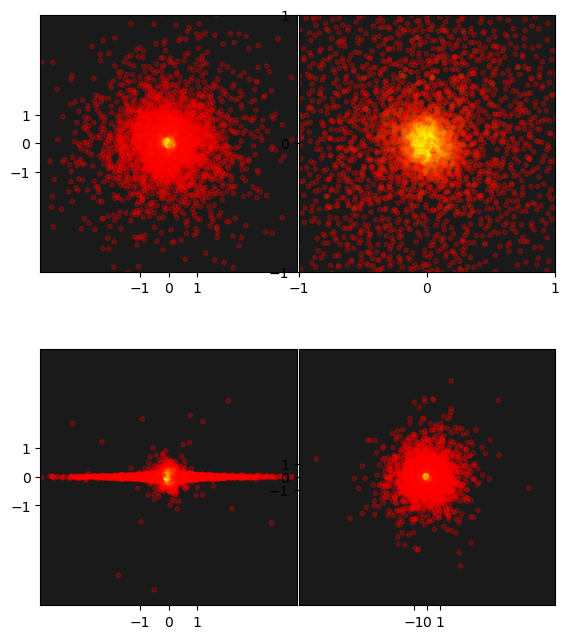

100%|██████████| 30/30 [4:39:31<00:00, 559.04s/it]


In [51]:
np.random.seed(42)            # set the random number generator seed
gal1 = Galaxy(N, mass = M, radius = R, scaleheight = 0.05, randvel = 0.0006,G = G,  k = k , n = n, nu = nu)
simulation = gal1.simulate(smoothinglength = 0.04, tstep = 1, tEnd = 30)

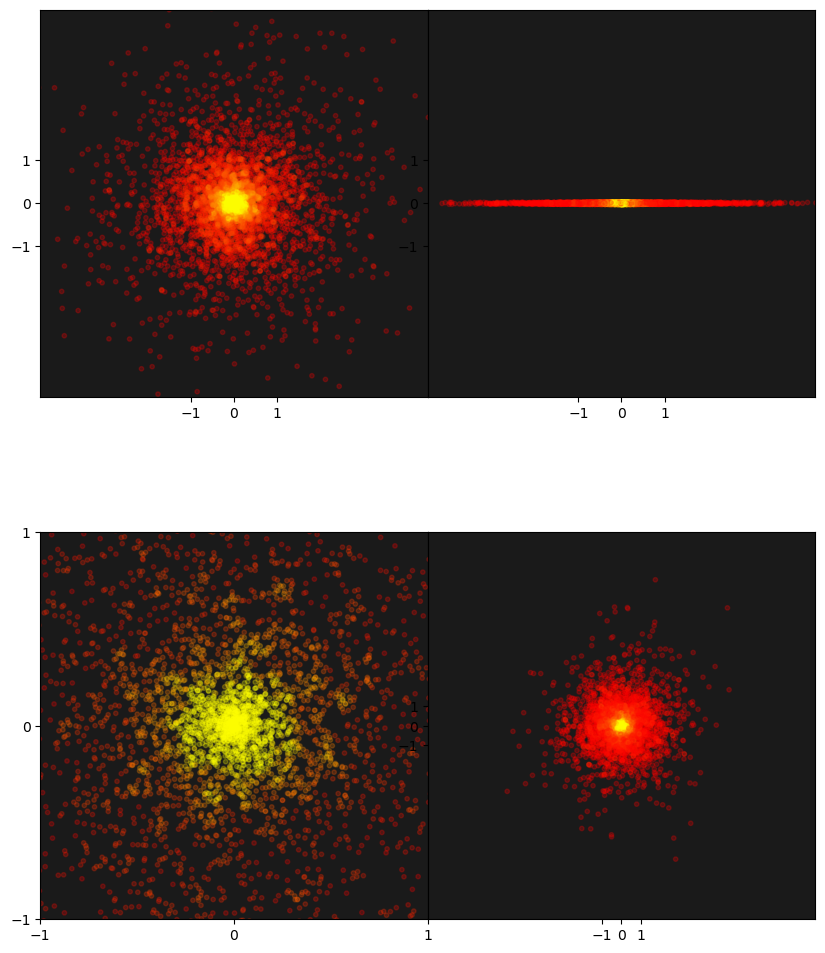

In [67]:
animation = gal1.quadplotvid()


Graphed at time 12.0


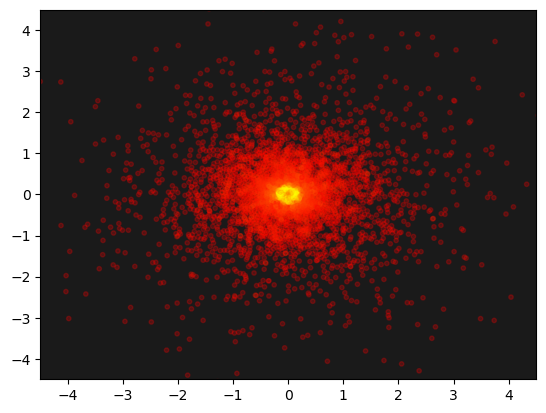

Graphed at time 12.0


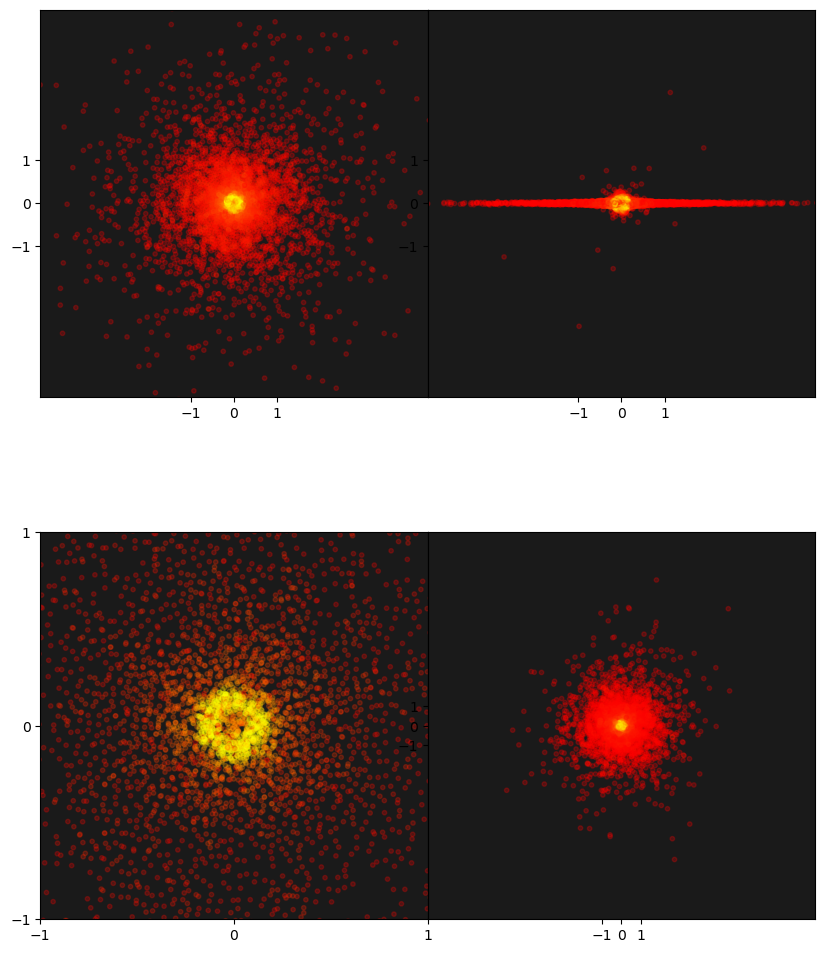

In [69]:
gal1.plot(time=20)
plt.show()
gal1.quadplot(time=20)

### Test Code 

In [21]:

timepull(gal1.simulation, 4)

3

In [ ]:
positions = simulation[0]
colors = simulation[1]



In [ ]:
from matplotlib import colors as clrs
plt.rcParams['animation.embed_limit'] = 2**128
# Downsampling by selecting every nth point
downsample_factor = 4 
positions1 = positions[::downsample_factor]
colors1 = colors[::downsample_factor] 



def update_plot(i):
    ax1.cla()
    ax2.cla()
    ax3.cla()
    ax4.cla()
    
    ax1.set(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
    ax1.set_aspect('equal', 'box')
    ax1.set_xticks([-1,0,1])
    ax1.set_yticks([-1,0,1])
    ax1.set_facecolor('black')
    ax1.set_facecolor((.1,.1,.1))
    ax1.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]), cmap=plt.cm.autumn, s=10, alpha=0.25)
    
    ax2.set(xlim=(-4.5, 4.5), ylim=(-4.5, 4.5))
    ax2.set_aspect('equal', 'box')
    ax2.set_xticks([-1,0,1])
    ax2.set_yticks([-1,0,1])
    ax2.set_facecolor('black')
    ax2.set_facecolor((.1,.1,.1)) 
    ax2.scatter(positions1[i][:,0], positions1[i][:,2], c=(colors1[i]), cmap=plt.cm.autumn, s=10, alpha=0.25)

    ax3.set(xlim=(-1, 1), ylim=(-1, 1))
    ax3.set_aspect('equal', 'box')
    ax3.set_xticks([-1,0,1])
    ax3.set_yticks([-1,0,1])
    ax3.set_facecolor('black')
    ax3.set_facecolor((.1,.1,.1))
    ax3.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]), cmap=plt.cm.autumn, s=10, alpha=0.25)

    ax4.set(xlim=(-10, 10), ylim=(-10, 10))
    ax4.set_aspect('equal', 'box')
    ax4.set_xticks([-1,0,1])
    ax4.set_yticks([-1,0,1])
    ax4.set_facecolor('black')
    ax4.set_facecolor((.1,.1,.1))
    ax4.scatter(positions1[i][:,0], positions1[i][:,1], c=(colors1[i]), cmap=plt.cm.autumn, s=10, alpha=0.25)

fig = plt.figure(figsize=(10,12), dpi=100)
grid = plt.GridSpec(2, 2, wspace=0.0, hspace=0.3)
ax1 = plt.subplot(grid[0,0])
ax2 = plt.subplot(grid[0,1])
ax3 = plt.subplot(grid[1,0])
ax4 = plt.subplot(grid[1,1])

#positions, colors = main()
ani = FuncAnimation(fig, update_plot, frames=len(positions1), interval=50, repeat=False)

HTML(ani.to_jshtml())

In [ ]:
ani.save('galaxyanimation6.mp4', writer = 'ffmpeg', fps = 24, dpi = 100)

we need a function to plot, quadplot, vidplot, vidquadplot

make the function so that it also graphs the initial conditions if no simulation has been run

make it so that the plot starts at the intial conditions and not one timestep after 

print the densities of these objects to find out what I should set the star forming density to
implement a boolean array that says whether an object is a star (really should be "isgas" because that makes the stars multiplier false
 

In the function below we need to multiply the bolean array by the W smoothing kernal function in some way so that the stars in the matrix are zero 

def getDensity( r, pos, m, h ):
	"""
	Get Density at sampling loctions from SPH particle distribution
	r     is an M x 3 matrix of sampling locations
	pos   is an N x 3 matrix of SPH particle positions
	m     is the particle mass
	h     is the smoothing length
	rho   is M x 1 vector of densities
	"""
	
	M = r.shape[0]
	
	dx, dy, dz = getPairwiseSeparations( r, pos );
	
	rho = np.sum( m * W(dx, dy, dz, h), 1 ).reshape((M,1))
	
	return rho

 then multiply boolean by final acceleration array
right before this 
a += arbacalc3d_vectorized(G, pos, m*(np.ones(len(pos))))

then calculate radiation pressure 



then 
    
add variable for the fps thing in the plot function 
 